##### Copyright 2018 The TensorFlow Authors.


#@title Licensed under the Apache License, Version 2.0 (the "License");
#### you may not use this file except in compliance with the License.
#### You may obtain a copy of the License at
####
#### https://www.apache.org/licenses/LICENSE-2.0
####
#### Unless required by applicable law or agreed to in writing, software
#### distributed under the License is distributed on an "AS IS" BASIS,
#### WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#### See the License for the specific language governing permissions and
#### limitations under the License.

# Image captioning with visual attention

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/text/image_captioning">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/text/image_captioning.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/text/image_captioning.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/text/image_captioning.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

Given an image like the example below, our goal is to generate a caption such as "a surfer riding on a wave".

![Man Surfing](https://tensorflow.org/images/surf.jpg)

*[Image Source](https://commons.wikimedia.org/wiki/Surfing#/media/File:Surfing_in_Hawaii.jpg); License: Public Domain*

To accomplish this, you'll use an attention-based model, which enables us to see what parts of the image the model focuses on as it generates a caption.

![Prediction](https://tensorflow.org/images/imcap_prediction.png)

The model architecture is similar to [Show, Attend and Tell: Neural Image Caption Generation with Visual Attention](https://arxiv.org/abs/1502.03044).

This notebook is an end-to-end example. When you run the notebook, it downloads the [MS-COCO](http://cocodataset.org/#home) dataset, preprocesses and caches a subset of images using Inception V3, trains an encoder-decoder model, and generates captions on new images using the trained model.

In this example, you will train a model on a relatively small amount of data—the first 30,000 captions  for about 20,000 images (because there are multiple captions per image in the dataset).

In [1]:
import tensorflow as tf

# You'll generate plots of attention in order to see which parts of an image
# our model focuses on during captioning
import matplotlib.pyplot as plt

# Scikit-learn includes many helpful utilities
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import re
import numpy as np
import os
import time
import json
from glob import glob
from PIL import Image
import pickle

In [2]:
tf.__version__

'2.2.0'

In [3]:
os.getcwd()

'D:\\courses\\img_captioning'

## Download and prepare the MS-COCO dataset

You will use the [MS-COCO dataset](http://cocodataset.org/#home) to train our model. The dataset contains over 82,000 images, each of which has at least 5 different caption annotations. The code below downloads and extracts the dataset automatically.

**Caution: large download ahead**. You'll use the training set, which is a 13GB file.

In [4]:
annotation_folder = os.getcwd() + '\\img_caption_2\\annotations'

In [5]:
annotation_folder

'D:\\courses\\img_captioning\\img_caption_2\\annotations'

In [6]:
# Download caption annotation files
# annotation_folder = os.getcwd() + '/img_caption_2/annotations'
if not os.path.exists(annotation_folder):
  annotation_zip = tf.keras.utils.get_file('captions.zip',
                                          cache_subdir=os.path.abspath(os.getcwd() + '\\img_caption_2' ),
                                          origin = 'http://images.cocodataset.org/annotations/annotations_trainval2014.zip',
                                          extract = True)
  annotation_file = annotation_folder + '\\captions_train2014.json'
#   os.remove(annotation_zip)
else:
  annotation_file = annotation_folder + '\\captions_train2014.json'

In [7]:
# Download image files
image_folder = os.getcwd() + '\\img_caption_2\\train2014' 
# '/content/drive/My Drive/img_caption_2/train2014/'
if not os.path.exists(image_folder):
  image_zip = tf.keras.utils.get_file('train2014.zip',
                                      cache_subdir=os.path.abspath(os.getcwd() + '\\img_caption_2' ),
                                      origin = 'http://images.cocodataset.org/zips/train2014.zip',
                                      extract = True)
  PATH = image_folder
  os.remove(image_zip)
else:
  PATH = image_folder

In [8]:
PATH

'D:\\courses\\img_captioning\\img_caption_2\\train2014'

## Optional: limit the size of the training set 
To speed up training for this tutorial, you'll use a subset of 30,000 captions and their corresponding images to train our model. Choosing to use more data would result in improved captioning quality.

In [9]:
# Read the json file
with open(annotation_file, 'r') as f:
    annotations = json.load(f)


In [10]:
len(annotations)

4

In [11]:
annotations.keys()

dict_keys(['info', 'images', 'licenses', 'annotations'])

In [12]:
len(annotations['annotations'])

414113

In [13]:
annotations['annotations'][:10]

[{'image_id': 318556,
  'id': 48,
  'caption': 'A very clean and well decorated empty bathroom'},
 {'image_id': 116100,
  'id': 67,
  'caption': 'A panoramic view of a kitchen and all of its appliances.'},
 {'image_id': 318556,
  'id': 126,
  'caption': 'A blue and white bathroom with butterfly themed wall tiles.'},
 {'image_id': 116100,
  'id': 148,
  'caption': 'A panoramic photo of a kitchen and dining room'},
 {'image_id': 379340,
  'id': 173,
  'caption': 'A graffiti-ed stop sign across the street from a red car '},
 {'image_id': 379340,
  'id': 188,
  'caption': 'A vandalized stop sign and a red beetle on the road'},
 {'image_id': 318556,
  'id': 219,
  'caption': 'A bathroom with a border of butterflies and blue paint on the walls above it.'},
 {'image_id': 318556,
  'id': 255,
  'caption': 'An angled view of a beautifully decorated bathroom.'},
 {'image_id': 134754,
  'id': 272,
  'caption': 'The two people are walking down the beach.'},
 {'image_id': 538480,
  'id': 288,
  'ca

In [14]:
annotations['info']

{'description': 'COCO 2014 Dataset',
 'url': 'http://cocodataset.org',
 'version': '1.0',
 'year': 2014,
 'contributor': 'COCO Consortium',
 'date_created': '2017/09/01'}

In [15]:

# Store captions and image names in vectors
all_captions = []
all_img_name_vector = []

for annot in annotations['annotations']:
    caption = '<start> ' + annot['caption'] + ' <end>'
    image_id = annot['image_id']
    full_coco_image_path = PATH + '\\COCO_train2014_' + '%012d.jpg' % (image_id)

    all_img_name_vector.append(full_coco_image_path)
    all_captions.append(caption)

# Shuffle captions and image_names together
# Set a random state
train_captions, img_name_vector = shuffle(all_captions,
                                          all_img_name_vector,
                                          random_state=1)

# Select the first 30000 captions from the shuffled set
num_examples = 30000
train_captions = train_captions[:num_examples]
img_name_vector = img_name_vector[:num_examples]

In [16]:
print(len(all_captions))
print(len(all_img_name_vector))

414113
414113


In [17]:
train_captions[:10]

['<start> A skateboarder performing a trick on a skateboard ramp. <end>',
 '<start> a person soaring through the air on skis <end>',
 '<start> a wood door with some boards laid against it <end>',
 '<start> A Do Not Enter sign is posted along a road leading to a stadium. <end>',
 '<start> Small child in a high chair eating off of a green plate.  <end>',
 '<start> groups of people standing around the toilet area <end>',
 '<start> a hand is holding a black and silver cellphone <end>',
 '<start> People working on laptop computers in a student dining room <end>',
 '<start> two birds near one another in a field  <end>',
 '<start> A man talking on a cell phone in a park. <end>']

In [18]:
img_name_vector[:10]

['D:\\courses\\img_captioning\\img_caption_2\\train2014\\COCO_train2014_000000324909.jpg',
 'D:\\courses\\img_captioning\\img_caption_2\\train2014\\COCO_train2014_000000511972.jpg',
 'D:\\courses\\img_captioning\\img_caption_2\\train2014\\COCO_train2014_000000508809.jpg',
 'D:\\courses\\img_captioning\\img_caption_2\\train2014\\COCO_train2014_000000270497.jpg',
 'D:\\courses\\img_captioning\\img_caption_2\\train2014\\COCO_train2014_000000008014.jpg',
 'D:\\courses\\img_captioning\\img_caption_2\\train2014\\COCO_train2014_000000269577.jpg',
 'D:\\courses\\img_captioning\\img_caption_2\\train2014\\COCO_train2014_000000527748.jpg',
 'D:\\courses\\img_captioning\\img_caption_2\\train2014\\COCO_train2014_000000109008.jpg',
 'D:\\courses\\img_captioning\\img_caption_2\\train2014\\COCO_train2014_000000339535.jpg',
 'D:\\courses\\img_captioning\\img_caption_2\\train2014\\COCO_train2014_000000425647.jpg']

Populating the interactive namespace from numpy and matplotlib


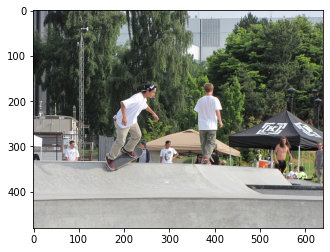

<start> A skateboarder performing a trick on a skateboard ramp. <end>
(480, 640, 3)
[[[136 146 158]
  [129 134 153]
  [128 134 156]
  ...
  [213 222 237]
  [213 222 237]
  [213 222 237]]

 [[136 148 160]
  [131 137 153]
  [126 132 154]
  ...
  [213 222 237]
  [213 222 237]
  [213 222 237]]

 [[136 150 161]
  [133 140 156]
  [127 134 153]
  ...
  [214 223 238]
  [214 223 238]
  [213 222 237]]

 ...

 [[177 174 169]
  [183 180 175]
  [186 185 181]
  ...
  [166 165 163]
  [163 163 161]
  [164 166 163]]

 [[185 182 175]
  [186 183 178]
  [177 176 171]
  ...
  [161 160 158]
  [162 162 162]
  [166 168 167]]

 [[187 184 177]
  [191 188 181]
  [182 181 176]
  ...
  [161 159 160]
  [162 162 162]
  [164 165 167]]]


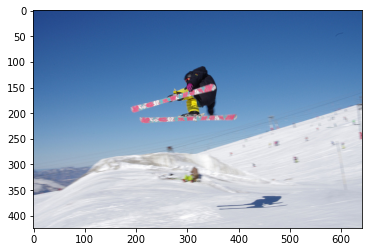

<start> a person soaring through the air on skis <end>
(424, 640, 3)
[[[ 36  69 140]
  [ 35  70 138]
  [ 35  70 136]
  ...
  [ 39  85 147]
  [ 39  85 147]
  [ 39  85 147]]

 [[ 34  68 139]
  [ 34  69 137]
  [ 35  70 136]
  ...
  [ 40  85 150]
  [ 41  85 150]
  [ 41  85 150]]

 [[ 35  70 138]
  [ 34  69 135]
  [ 34  69 135]
  ...
  [ 41  84 152]
  [ 42  86 151]
  [ 42  86 151]]

 ...

 [[214 217 224]
  [215 218 225]
  [216 219 226]
  ...
  [206 211 217]
  [205 210 216]
  [204 209 215]]

 [[215 218 225]
  [216 219 226]
  [216 219 226]
  ...
  [210 214 223]
  [211 215 224]
  [211 215 224]]

 [[216 219 226]
  [216 219 226]
  [215 218 225]
  ...
  [201 205 216]
  [202 206 217]
  [202 206 217]]]


In [23]:
%pylab inline
import matplotlib.image as mpimg
img=mpimg.imread(img_name_vector[0])
imgplot = plt.imshow(img)
plt.show()

print(train_captions[0])
print(img.shape)
print(img)

img=mpimg.imread(img_name_vector[1])
imgplot = plt.imshow(img)
plt.show()

print(train_captions[1])
print(img.shape)
print(img)

In [24]:
img[0]

array([[ 36,  69, 140],
       [ 35,  70, 138],
       [ 35,  70, 136],
       ...,
       [ 39,  85, 147],
       [ 39,  85, 147],
       [ 39,  85, 147]], dtype=uint8)

In [25]:
img[0].shape

(640, 3)

In [26]:
len(train_captions), len(all_captions)

(30000, 414113)

## Preprocess the images using InceptionV3
Next, you will use InceptionV3 (which is pretrained on Imagenet) to classify each image. You will extract features from the last convolutional layer.

First, you will convert the images into InceptionV3's expected format by:
* Resizing the image to 299px by 299px
* [Preprocess the images](https://cloud.google.com/tpu/docs/inception-v3-advanced#preprocessing_stage) using the [preprocess_input](https://www.tensorflow.org/api_docs/python/tf/keras/applications/inception_v3/preprocess_input) method to normalize the image so that it contains pixels in the range of -1 to 1, which matches the format of the images used to train InceptionV3.

In [27]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

## Initialize InceptionV3 and load the pretrained Imagenet weights

Now you'll create a tf.keras model where the output layer is the last convolutional layer in the InceptionV3 architecture. The shape of the output of this layer is ```8x8x2048```. You use the last convolutional layer because you are using attention in this example. You don't perform this initialization during training because it could become a bottleneck.

* You forward each image through the network and store the resulting vector in a dictionary (image_name --> feature_vector).
* After all the images are passed through the network, you pickle the dictionary and save it to disk.

#### help(tf.keras.Model)

`Model` groups layers into an object with training and inference features.
There are two ways to instantiate a `Model`:

1. With the "functional API", where you start from `Input`,
you chain layer calls to specify the model's forward pass,
and finally you create your model from inputs and outputs:

### it's use this form
```python
import tensorflow as tf

inputs = tf.keras.Input(shape=(3,))
x = tf.keras.layers.Dense(4, activation=tf.nn.relu)(inputs)
outputs = tf.keras.layers.Dense(5, activation=tf.nn.softmax)(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs)


In [28]:
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')

In [29]:
len(image_model.get_weights())

376

In [30]:
new_input = image_model.input

In [31]:
new_input

<tf.Tensor 'input_1:0' shape=(None, None, None, 3) dtype=float32>

In [32]:
hidden_layer = image_model.layers[-1].output

In [33]:
hidden_layer

<tf.Tensor 'mixed10/Identity:0' shape=(None, None, None, 2048) dtype=float32>

In [34]:
image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

In [35]:
image_features_extract_model # image features extractor

In [36]:
image_features_extract_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
______________________________________________________________________________________________

## Caching the features extracted from InceptionV3

You will pre-process each image with InceptionV3 and cache the output to disk. Caching the output in RAM would be faster but also memory intensive, requiring 8 \* 8 \* 2048 floats per image. At the time of writing, this exceeds the memory limitations of Colab (currently 12GB of memory).

Performance could be improved with a more sophisticated caching strategy (for example, by sharding the images to reduce random access disk I/O), but that would require more code.

The caching will take about 10 minutes to run in Colab with a GPU. If you'd like to see a progress bar, you can: 

1. install [tqdm](https://github.com/tqdm/tqdm):

    `!pip install tqdm`

2. Import tqdm:

    `from tqdm import tqdm`

3. Change the following line:

    `for img, path in image_dataset:`

    to:

    `for img, path in tqdm(image_dataset):`


In [37]:
# !pip install tqdm

In [38]:
from tqdm import tqdm

In [39]:
# Get unique images
encode_train = sorted(set(img_name_vector)) # 30000 img deduplicate which has the same name

In [40]:
len(encode_train) # 

25950

In [41]:
encode_train[:5]

['D:\\courses\\img_captioning\\img_caption_2\\train2014\\COCO_train2014_000000000025.jpg',
 'D:\\courses\\img_captioning\\img_caption_2\\train2014\\COCO_train2014_000000000049.jpg',
 'D:\\courses\\img_captioning\\img_caption_2\\train2014\\COCO_train2014_000000000077.jpg',
 'D:\\courses\\img_captioning\\img_caption_2\\train2014\\COCO_train2014_000000000078.jpg',
 'D:\\courses\\img_captioning\\img_caption_2\\train2014\\COCO_train2014_000000000081.jpg']

In [42]:
# Feel free to change batch_size according to your system configuration
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)


In [43]:
image_dataset

<TensorSliceDataset shapes: (), types: tf.string>

In [44]:
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16) # map functional programming


In [45]:
image_dataset

<BatchDataset shapes: ((None, 299, 299, 3), (None,)), types: (tf.float32, tf.string)>

In [46]:
for img, path in tqdm(image_dataset):
  batch_features = image_features_extract_model(img) # image features extractor model
  batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

  for bf, p in zip(batch_features, path): # bf : batch feature , p : path
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())
# - `store the resulting vector` `in a dictionary` (image_name --> feature_vector).
# - you pickle the dictionary and save it to disk.

1622it [07:44,  3.49it/s]


## Preprocess and tokenize the captions

* First, you'll tokenize the captions (for example, by splitting on spaces). This gives us a  vocabulary of all of the unique words in the data (for example, "surfing", "football", and so on).
* Next, you'll limit the vocabulary size to the top 5,000 words (to save memory). You'll replace all other words with the token "UNK" (unknown).
* You then create word-to-index and index-to-word mappings.
* Finally, you pad all sequences to be the same length as the longest one.

In [47]:
# Find the maximum length of any caption in our dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [48]:
# Choose the top 5000 words from the vocabulary
top_k = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(train_captions)
train_seqs = tokenizer.texts_to_sequences(train_captions)

In [49]:
train_seqs[:5]

[[3, 2, 351, 687, 2, 280, 5, 2, 84, 339, 4],
 [3, 2, 31, 2356, 112, 7, 137, 5, 159, 4],
 [3, 2, 318, 284, 9, 28, 525, 1083, 305, 30, 4],
 [3, 2, 1118, 845, 1539, 57, 11, 1203, 219, 2, 91, 1008, 13, 2, 1290, 4],
 [3, 37, 152, 8, 2, 376, 155, 127, 214, 6, 2, 65, 39, 4]]

In [50]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [51]:
tokenizer.index_word[0]

'<pad>'

In [52]:
# print(tokenizer.word_index.items()[:5])
for i, (k,v) in enumerate(tokenizer.word_index.items()):
  print(i,k,v)
  if i == 10:
    break
# print(tokenizer.index_word.items()[:5])
print("-"*10)
for i, (k,v) in enumerate(tokenizer.index_word.items()):
  print(i,k,v)
  if i == 10:
    break

0 <unk> 1
1 a 2
2 <start> 3
3 <end> 4
4 on 5
5 of 6
6 the 7
7 in 8
8 with 9
9 and 10
10 is 11
----------
0 1 <unk>
1 2 a
2 3 <start>
3 4 <end>
4 5 on
5 6 of
6 7 the
7 8 in
8 9 with
9 10 and
10 11 is


In [53]:
# Create the tokenized vectors
train_seqs = tokenizer.texts_to_sequences(train_captions)

In [54]:
train_seqs[:5]

[[3, 2, 351, 687, 2, 280, 5, 2, 84, 339, 4],
 [3, 2, 31, 2356, 112, 7, 137, 5, 159, 4],
 [3, 2, 318, 284, 9, 28, 525, 1083, 305, 30, 4],
 [3, 2, 1118, 845, 1539, 57, 11, 1203, 219, 2, 91, 1008, 13, 2, 1290, 4],
 [3, 37, 152, 8, 2, 376, 155, 127, 214, 6, 2, 65, 39, 4]]

In [55]:
# Pad each vector to the max_length of the captions
# If you do not provide a max_length value, pad_sequences calculates it automatically
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

In [56]:
cap_vector.shape

(30000, 49)

In [57]:
cap_vector[:5]

array([[   3,    2,  351,  687,    2,  280,    5,    2,   84,  339,    4,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0],
       [   3,    2,   31, 2356,  112,    7,  137,    5,  159,    4,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0],
       [   3,    2,  318,  284,    9,   28,  525, 1083,  305,   30,    4,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,   

In [58]:
# Calculates the max_length, which is used to store the attention weights
max_length = calc_max_length(train_seqs)

In [59]:
max_length

49

## Split the data into training and testing

In [60]:
# Create training and validation sets using an 80-20 split
img_name_train, img_name_val, cap_train, cap_val = train_test_split(img_name_vector,
                                                                    cap_vector,
                                                                    test_size=0.2,
                                                                    random_state=0)

In [61]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(24000, 24000, 6000, 6000)

In [62]:
img_name_train[:5]

['D:\\courses\\img_captioning\\img_caption_2\\train2014\\COCO_train2014_000000313360.jpg',
 'D:\\courses\\img_captioning\\img_caption_2\\train2014\\COCO_train2014_000000371839.jpg',
 'D:\\courses\\img_captioning\\img_caption_2\\train2014\\COCO_train2014_000000157202.jpg',
 'D:\\courses\\img_captioning\\img_caption_2\\train2014\\COCO_train2014_000000271999.jpg',
 'D:\\courses\\img_captioning\\img_caption_2\\train2014\\COCO_train2014_000000306822.jpg']

In [63]:
cap_train[:5]

array([[   3,   29,   53,   19,   89,  202,  100,   92,    5,    7,  218,
           4,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0],
       [   3,    1,  212,    8,    2,  206,    5,    2,   25,    4,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0],
       [   3,    2,   31,   47,    5,    2,  126, 3004,  271, 1177,  112,
           2, 1579,    4,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,   

## Create a tf.data dataset for training


 Our images and captions are ready! Next, let's create a tf.data dataset to use for training our model.

In [64]:
# Feel free to change these parameters according to your system's configuration

BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = top_k + 1
num_steps = len(img_name_train) // BATCH_SIZE  # 24000 / 64

In [65]:
24000 / 64

375.0

In [66]:
num_steps

375

In [67]:
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 64

In [68]:
# Load the numpy files
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap

In [69]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

In [70]:
dataset

<TensorSliceDataset shapes: ((), (49,)), types: (tf.string, tf.int32)>

In [71]:
# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [72]:
dataset

<ParallelMapDataset shapes: (<unknown>, <unknown>), types: (tf.float32, tf.int32)>

In [73]:
# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [74]:
dataset

<BatchDataset shapes: (<unknown>, <unknown>), types: (tf.float32, tf.int32)>

In [75]:
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [76]:
dataset

<PrefetchDataset shapes: (<unknown>, <unknown>), types: (tf.float32, tf.int32)>

## Model

Fun fact: the decoder below is identical to the one in the example for [Neural Machine Translation with Attention](../sequences/nmt_with_attention.ipynb).

The model architecture is inspired by the [Show, Attend and Tell](https://arxiv.org/pdf/1502.03044.pdf) paper.

* In this example, you extract the features from the lower convolutional layer of InceptionV3 giving us a vector of shape (8, 8, 2048).
* You squash that to a shape of (64, 2048).
* This vector is then passed through the CNN Encoder (which consists of a single Fully connected layer).
* The RNN (here GRU) attends over the image to predict the next word.

In [77]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # score shape == (batch_size, 64, hidden_size)
    score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))

    # attention_weights shape == (batch_size, 64, 1)
    # you get 1 at the last axis because you are applying score to self.V
    attention_weights = tf.nn.softmax(self.V(score), axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [78]:
BahdanauAttention_cek = BahdanauAttention(units=units)

In [79]:
# BahdanauAttention_cek.summary()

In [80]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it using pickle
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [81]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [82]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

In [83]:
encoder

In [84]:
decoder

In [85]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

## Checkpoint

In [86]:
os.getcwd()

'D:\\courses\\img_captioning'

In [87]:
checkpoint_path = os.getcwd() + "\\checkpoints\\train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [88]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)

## Training

* You extract the features stored in the respective `.npy` files and then pass those features through the encoder.
* The encoder output, hidden state(initialized to 0) and the decoder input (which is the start token) is passed to the decoder.
* The decoder returns the predictions and the decoder hidden state.
* The decoder hidden state is then passed back into the model and the predictions are used to calculate the loss.
* Use teacher forcing to decide the next input to the decoder.
* Teacher forcing is the technique where the target word is passed as the next input to the decoder.
* The final step is to calculate the gradients and apply it to the optimizer and backpropagate.


In [89]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []

In [90]:
@tf.function
def train_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)

          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

In [91]:
EPOCHS = 20

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(
              epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
      ckpt_manager.save()

    print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                         total_loss/num_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 2.0540
Epoch 1 Batch 100 Loss 1.0787
Epoch 1 Batch 200 Loss 1.0129
Epoch 1 Batch 300 Loss 0.9620
Epoch 1 Loss 1.043563
Time taken for 1 epoch 197.12411236763 sec

Epoch 2 Batch 0 Loss 0.7701
Epoch 2 Batch 100 Loss 0.8415
Epoch 2 Batch 200 Loss 0.7781
Epoch 2 Batch 300 Loss 0.8299
Epoch 2 Loss 0.798495
Time taken for 1 epoch 1069.4797677993774 sec

Epoch 3 Batch 0 Loss 0.7163
Epoch 3 Batch 100 Loss 0.7350
Epoch 3 Batch 200 Loss 0.6946
Epoch 3 Batch 300 Loss 0.6910
Epoch 3 Loss 0.726183
Time taken for 1 epoch 1604.50190615654 sec

Epoch 4 Batch 0 Loss 0.7400
Epoch 4 Batch 100 Loss 0.6398
Epoch 4 Batch 200 Loss 0.6568
Epoch 4 Batch 300 Loss 0.6932
Epoch 4 Loss 0.680406
Time taken for 1 epoch 865.7974989414215 sec

Epoch 5 Batch 0 Loss 0.6275
Epoch 5 Batch 100 Loss 0.6407
Epoch 5 Batch 200 Loss 0.6344
Epoch 5 Batch 300 Loss 0.6231
Epoch 5 Loss 0.644008
Time taken for 1 epoch 507.5963463783264 sec

Epoch 6 Batch 0 Loss 0.5997
Epoch 6 Batch 100 Loss 0.6193
Epoch 6 Batch 

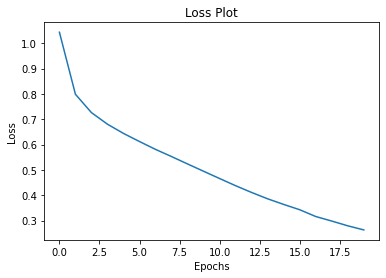

In [92]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

## Caption!

* The evaluate function is similar to the training loop, except you don't use teacher forcing here. The input to the decoder at each time step is its previous predictions along with the hidden state and the encoder output.
* Stop predicting when the model predicts the end token.
* And store the attention weights for every time step.

In [93]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [94]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

Real Caption: <start> a stop sign on the side of a clear road <end>
Prediction Caption: a stop sign in front of a railing of a railing of a jump <end>


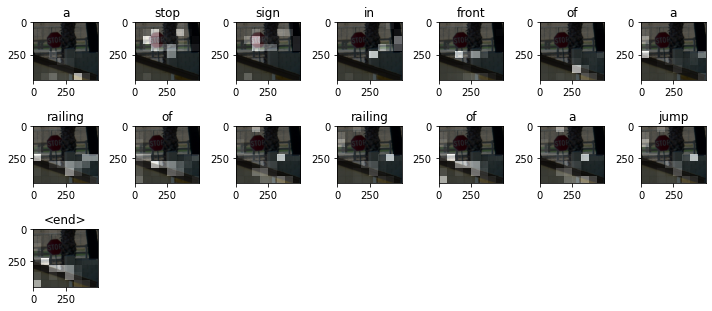

In [95]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)


## Try it on your own images
For fun, below we've provided a method you can use to caption your own images with the model we've just trained. Keep in mind, it was trained on a relatively small amount of data, and your images may be different from the training data (so be prepared for weird results!)


65536/64400 [==============================] - 0s 4us/step
Prediction Caption: a surfer makes a surfboard in the water <end>


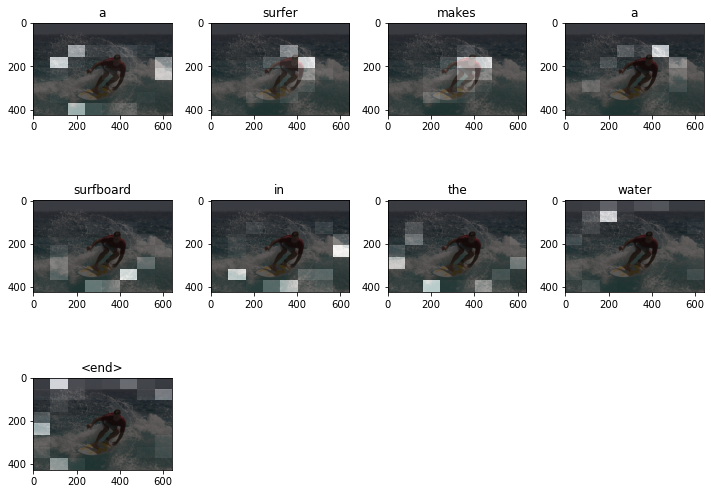

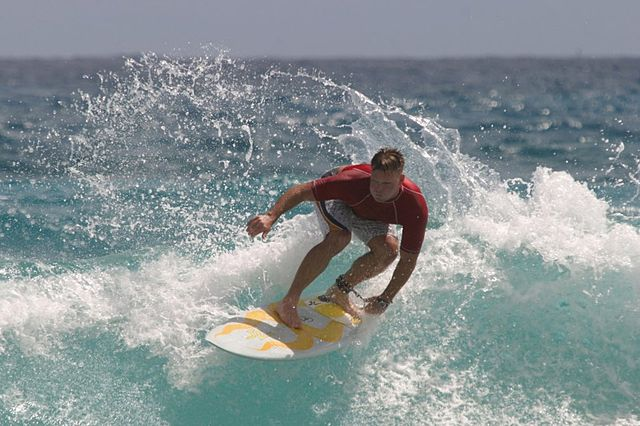

In [96]:
image_url = 'https://tensorflow.org/images/surf.jpg'
image_extension = image_url[-4:]
image_path = tf.keras.utils.get_file('image'+image_extension,
                                     origin=image_url)

result, attention_plot = evaluate(image_path)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image_path, result, attention_plot)
# opening the image
Image.open(image_path)

# Next steps

Congrats! You've just trained an image captioning model with attention. Next, take a look at this example [Neural Machine Translation with Attention](../sequences/nmt_with_attention.ipynb). It uses a similar architecture to translate between Spanish and English sentences. You can also experiment with training the code in this notebook on a different dataset.